<a href="https://colab.research.google.com/github/SalmaKaiss-ui/DS/blob/main/Kaiss_Salma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Summarize the entire process and provide the final output, including data loading, cleaning, EDA, model training, and performance evaluation for the breast cancer tabular dataset.

## Load_Data_and_Define_Dataset

### Subtask:
Load the brain MRI images dataset, manage file paths, apply necessary image transformations (like resizing and converting to tensor), and define a custom PyTorch `Dataset` class to handle image loading.


**Reasoning**:
The subtask requires loading the brain MRI dataset, managing file paths, applying image transformations, and defining a custom PyTorch `Dataset` class. This involves several steps: importing libraries, defining paths, listing images, creating transformations, implementing the `Dataset` class, and instantiating it. I will combine all these into a single code block for efficiency.



In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

print("Loading brain MRI images dataset, managing file paths, applying image transformations, and defining custom PyTorch Dataset...")

# 1. Define the root directory where the brain MRI dataset is located.
dataset_root_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'

# Construct full paths to the 'no' and 'yes' tumor image subdirectories.
no_path = os.path.join(dataset_root_dir, 'no')
yes_path = os.path.join(dataset_root_dir, 'yes')

# 2. Create two lists, `no_tumor_images_list` and `yes_tumor_images_list`,
#    containing the full paths to all image files within their respective directories.
no_tumor_images_list = [os.path.join(no_path, img_name) for img_name in os.listdir(no_path)]
yes_tumor_images_list = [os.path.join(yes_path, img_name) for img_name in os.listdir(yes_path)]

# 3. Define a sequence of image transformations
IMG_HEIGHT = 128
IMG_WIDTH = 128

transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), # Resize to a consistent size
    transforms.ToTensor(),                       # Convert image to PyTorch Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize pixel values
])

# 4. Implement a custom PyTorch `Dataset` class
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # Ensure 3 channels
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# 5. Concatenate the image lists and create corresponding labels
all_image_paths = no_tumor_images_list + yes_tumor_images_list
all_labels = [0] * len(no_tumor_images_list) + [1] * len(yes_tumor_images_list)

# 6. Instantiate the `BrainTumorDataset` class
brain_tumor_dataset = BrainTumorDataset(all_image_paths, all_labels, transforms)

print(f"Dataset loaded with {len(brain_tumor_dataset)} images.")
print("First image path:", brain_tumor_dataset.image_paths[0])
print("First image label:", brain_tumor_dataset.labels[0])
print("Data loading and Dataset definition complete.")

Loading brain MRI images dataset, managing file paths, applying image transformations, and defining custom PyTorch Dataset...
Dataset loaded with 253 images.
First image path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no/34 no.jpg
First image label: 0
Data loading and Dataset definition complete.


## Split_Data_and_Create_DataLoaders

### Subtask:
Split the custom PyTorch Dataset into training, validation, and test sets. Then, create `DataLoader` instances for each set to efficiently feed data into the model in batches.


**Reasoning**:
I will import the necessary PyTorch utilities, define the dataset split proportions, apply random_split to create train, validation, and test datasets, define the batch size, and then create DataLoader instances for each split, finally printing their sizes and batch counts to verify the data preparation.



In [ ]:
from torch.utils.data import random_split, DataLoader

print("Splitting dataset and creating DataLoaders...")

# 1. Define the proportions for the training, validation, and test sets
# Use 70% for training, 15% for validation, and 15% for testing
DATASET_SIZE = len(brain_tumor_dataset)
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

train_size = int(TRAIN_SPLIT * DATASET_SIZE)
val_size = int(VAL_SPLIT * DATASET_SIZE)
test_size = DATASET_SIZE - train_size - val_size # Adjust test_size to ensure sum equals total size

# 2. Use torch.utils.data.random_split to divide the dataset
# Set a generator for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(brain_tumor_dataset, [train_size, val_size, test_size], generator=generator)

# 3. Define a BATCH_SIZE
BATCH_SIZE = 32

# 4. Create DataLoader instances for each set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle validation data is generally not needed
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Print the size of each dataset split and the number of batches in each DataLoader
print(f"\nTotal dataset size: {DATASET_SIZE}")
print(f"Training set size: {len(train_dataset)} ({train_size})")
print(f"Validation set size: {len(val_dataset)} ({val_size})")
print(f"Test set size: {len(test_dataset)} ({test_size})")

print(f"\nNumber of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

print("Dataset splitting and DataLoader creation complete.")

Splitting dataset and creating DataLoaders...

Total dataset size: 253
Training set size: 177 (177)
Validation set size: 37 (37)
Test set size: 39 (39)

Number of batches in training loader: 6
Number of batches in validation loader: 2
Number of batches in test loader: 2
Dataset splitting and DataLoader creation complete.


## Exploratory_Data_Analysis_for_Images

### Subtask:
Perform exploratory data analysis tailored for the image dataset, including visualizing sample images from the loaded dataset and analyzing the distribution of classes (tumor vs. no tumor) using plots like pie charts and bar plots.


**Reasoning**:
To perform exploratory data analysis on the image dataset, I will first visualize a few sample images from the `train_dataset` to ensure they are loaded correctly and appear as expected. Then, I will calculate the distribution of 'no tumor' and 'yes tumor' classes across the entire `brain_tumor_dataset` and represent this distribution using both a pie chart and a bar plot. This will provide insights into the dataset's class balance.

**Reasoning**:
As requested by the instructions, I will now implement the code to visualize sample images from the training dataset, calculate the class distribution for the entire dataset, and then display this distribution using both a pie chart and a bar plot. This will fulfill the EDA requirements for the image dataset.



Performing Exploratory Data Analysis for Images...

Displaying sample images from the training dataset...


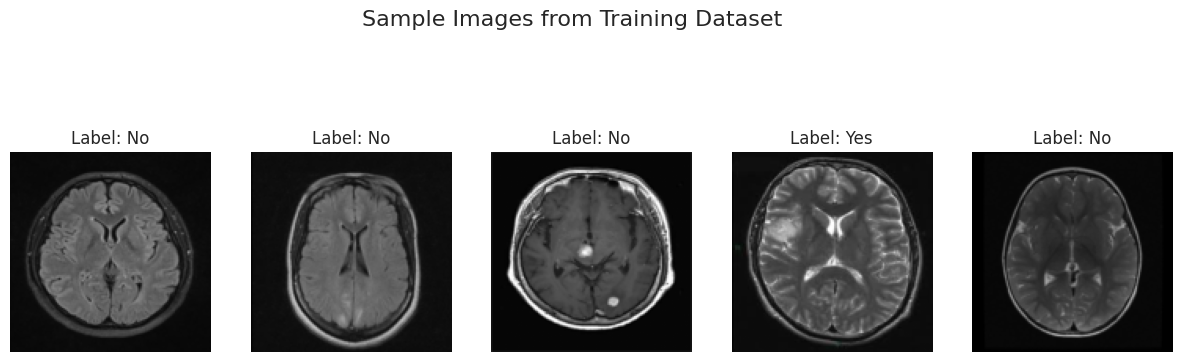


Calculating class distribution...
Class counts: No Tumor = 98, Yes Tumor = 155

Generating pie chart for class distribution...


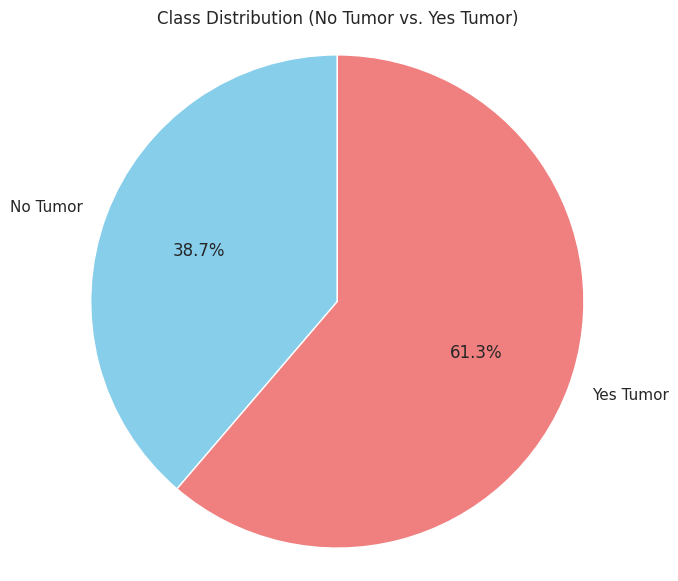


Generating bar plot for class distribution...


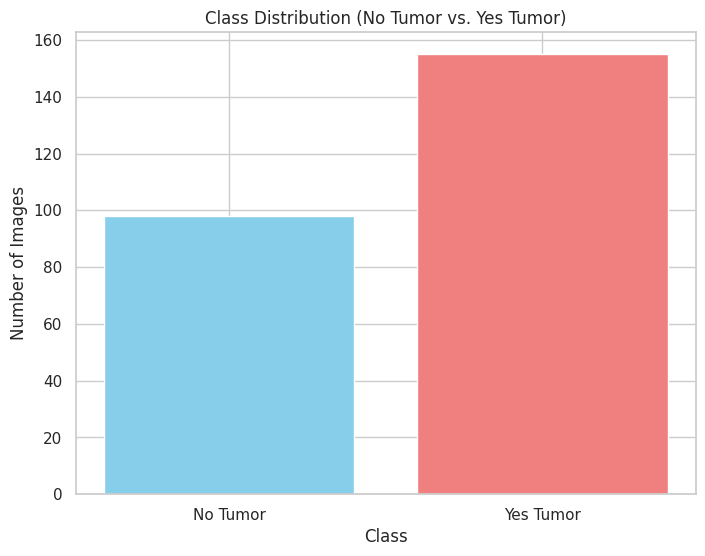

Image EDA complete.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms # Already imported, but explicitly here for ToPILImage

print("Performing Exploratory Data Analysis for Images...")

# --- 1. Visualize Sample Images from train_dataset ---

print("\nDisplaying sample images from the training dataset...")

# Denormalize transform for visualization (assuming normalize mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
inv_normalize = transforms.Normalize(mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5], std=[1/0.5, 1/0.5, 1/0.5])

num_images_to_display = 5
plt.figure(figsize=(15, 5))

# Iterate through the train_dataset to get images
for i in range(num_images_to_display):
    image, label = train_dataset[i]

    # Denormalize image for correct display
    img_display = inv_normalize(image)
    img_display = img_display.permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C)

    # Clip values to [0, 1] after denormalization, as some might fall outside due to float precision
    img_display = np.clip(img_display, 0, 1)

    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img_display)
    plt.title(f"Label: {'Yes' if label == 1 else 'No'}")
    plt.axis('off')
plt.suptitle('Sample Images from Training Dataset', fontsize=16)
plt.show()

# --- 2. Calculate Class Distribution Across Entire brain_tumor_dataset ---

print("\nCalculating class distribution...")
all_labels_dataset = [label for _, label in brain_tumor_dataset]

class_counts = {
    0: all_labels_dataset.count(0), # Count 'no tumor' labels
    1: all_labels_dataset.count(1)  # Count 'yes tumor' labels
}

class_names = ['No Tumor', 'Yes Tumor']
counts = [class_counts[0], class_counts[1]]

print(f"Class counts: No Tumor = {class_counts[0]}, Yes Tumor = {class_counts[1]}")

# --- 3. Create a Pie Chart for Class Distribution ---

print("\nGenerating pie chart for class distribution...")
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution (No Tumor vs. Yes Tumor)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# --- 4. Create a Bar Plot for Class Distribution ---

print("\nGenerating bar plot for class distribution...")
plt.figure(figsize=(8, 6))
plt.bar(class_names, counts, color=['skyblue', 'lightcoral'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution (No Tumor vs. Yes Tumor)')
plt.show()

print("Image EDA complete.")

## Define_CNN_Model_Architecture

### Subtask:
Implement the Convolutional Neural Network (CNN) model architecture using PyTorch's `nn.Module` based on the design presented in the Kaggle notebook.


#### Reasoning:
I will proceed by importing the `torch.nn` module as `nn` and then defining the `SimpleCNN` class, which will inherit from `nn.Module`. Within its `__init__` method, I will define a sequence of convolutional layers, ReLU activations, max-pooling layers, and dropout layers, followed by fully connected layers for classification. I will ensure the input size for the first linear layer is correctly calculated based on the output of the final convolutional block. The `forward` method will then specify the data flow through these layers. Finally, I will instantiate `SimpleCNN` as `model_cnn` and print its structure to confirm the architecture.

**Reasoning**:
I will implement the `SimpleCNN` class inheriting from `nn.Module`, defining convolutional layers with ReLU activations, max-pooling, and dropout, followed by fully connected layers for binary classification. The `forward` method will detail the data flow. Finally, I will instantiate the model and print its architecture to confirm the design.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

print("Defining the SimpleCNN model architecture...")

# 2. Define a class named SimpleCNN that inherits from nn.Module.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(0.25)

        # Calculate input size for the first fully connected layer
        # Input image size is 128x128. After 3 pooling layers (each halves spatial dim):
        # 128 -> 64 -> 32 -> 16
        # The last convolutional layer has 128 output channels.
        self.fc_input_features = 128 * (IMG_HEIGHT // (2**3)) * (IMG_WIDTH // (2**3)) # 128 * 16 * 16 = 32768

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc_input_features, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2) # 2 classes: tumor or no tumor

    def forward(self, x):
        # Conv Block 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        # Conv Block 2
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        # Conv Block 3
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1) # Flatten all dimensions except batch

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# 5. Instantiate the SimpleCNN model and print its architecture
model_cnn = SimpleCNN()
print("Model architecture:")
print(model_cnn)
print("SimpleCNN model architecture defined and instantiated.")

Defining the SimpleCNN model architecture...
Model architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
SimpleCNN model architecture defined and instantiated.


## Train_CNN_Model

### Subtask:
Implement the training loop for the defined CNN model. This includes setting up the optimizer, loss function, and training the model over a specified number of epochs using the training and validation DataLoaders.


#### Reasoning:
To train the `SimpleCNN` model, I will first identify and set the appropriate computing device (GPU if available, otherwise CPU). Then, I will initialize a suitable loss function for binary classification (`nn.CrossEntropyLoss`) and an optimizer (`torch.optim.Adam`) to update the model's weights. The core of the training will involve an iterative loop over a predefined number of epochs. Within each epoch, the model will process batches from the `train_loader`, calculate the loss, perform backpropagation, and update its parameters. After each training epoch, the model's performance will be evaluated on the `val_loader` to monitor its generalization capabilities. I will track and print both training and validation losses and accuracies to observe the learning progress.

**Reasoning**:
I will now implement the training loop for the CNN model, including setting up the device, defining the loss function and optimizer, and running the training and validation steps over multiple epochs as outlined in the instructions.



In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm # For progress bar

print("Setting up device, loss function, optimizer, and training the CNN model...")

# 1. Set up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn.to(device)
print(f"Using device: {device}")

# 2. Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss() # Suitable for 2 classes (0 or 1)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# Store training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Define number of epochs
epochs = 10 # Using a smaller number for demonstration, can be increased

# 3. Implement the training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Training Phase
    model_cnn.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}")

    # Validation Phase
    model_cnn.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_cnn(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_loader_tqdm.set_postfix(loss=loss.item())

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

print("\nCNN model training complete.")


Setting up device, loss function, optimizer, and training the CNN model...
Using device: cpu

Epoch 1/10


Training Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.0830, Train Accuracy: 0.5424


Validation Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6608, Validation Accuracy: 0.6486

Epoch 2/10


Training Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6690, Train Accuracy: 0.5819


Validation Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.6431, Validation Accuracy: 0.6486

Epoch 3/10


Training Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6250, Train Accuracy: 0.6497


Validation Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5920, Validation Accuracy: 0.7838

Epoch 4/10


Training Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6546, Train Accuracy: 0.6780


Validation Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5989, Validation Accuracy: 0.6757

Epoch 5/10


Training Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5552, Train Accuracy: 0.7401


Validation Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5315, Validation Accuracy: 0.7297

Epoch 6/10


Training Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5640, Train Accuracy: 0.6497


Validation Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5371, Validation Accuracy: 0.8108

Epoch 7/10


Training Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5407, Train Accuracy: 0.7684


Validation Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5090, Validation Accuracy: 0.8108

Epoch 8/10


Training Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4887, Train Accuracy: 0.7458


Validation Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5480, Validation Accuracy: 0.7297

Epoch 9/10


Training Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4886, Train Accuracy: 0.7797


Validation Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.4886, Validation Accuracy: 0.8108

Epoch 10/10


Training Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4332, Train Accuracy: 0.8192


Validation Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.4674, Validation Accuracy: 0.8378

CNN model training complete.


## Evaluate_CNN_Model

### Subtask:
Evaluate the trained CNN model's performance on the test set. Calculate and report key metrics such as accuracy, precision, recall, F1-score, and visualize the confusion matrix, similar to the evaluation in the provided notebook.


## Evaluate_CNN_Model

### Subtask:
Evaluate the trained CNN model's performance on the test set. Calculate and report key metrics such as accuracy, precision, recall, F1-score, and visualize the confusion matrix, similar to the evaluation in the provided notebook.

#### Instructions
1. Set the `model_cnn` to evaluation mode using `.eval()`.
2. Move the `model_cnn` to the appropriate device (CPU or GPU).
3. Initialize empty lists to store true labels and predicted labels from the test set.
4. Iterate through the `test_loader` with `torch.no_grad()` to disable gradient calculations.
5. For each batch, move inputs and labels to the device, get model outputs, and determine predicted classes.
6. Extend the true labels list with batch labels and the predicted labels list with predicted classes.
7. After iterating through all test data, calculate the classification report using `sklearn.metrics.classification_report` and print it.
8. Calculate the confusion matrix using `sklearn.metrics.confusion_matrix`.
9. Visualize the confusion matrix as a heatmap using `seaborn.heatmap`. Ensure the plot has a title, axis labels, and annotated values.

**Reasoning**:
I will proceed by creating a code block that evaluates the trained CNN model. This involves setting the model to evaluation mode, making predictions on the test set, collecting true and predicted labels, and then generating and printing the classification report and visualizing the confusion matrix.



Evaluating the CNN model performance on the test set...
Using device for evaluation: cpu

--- Classification Report for CNN Model ---
              precision    recall  f1-score   support

    No Tumor       0.60      0.75      0.67        12
   Yes Tumor       0.88      0.78      0.82        27

    accuracy                           0.77        39
   macro avg       0.74      0.76      0.75        39
weighted avg       0.79      0.77      0.78        39


Generating and displaying confusion matrix for CNN Model...


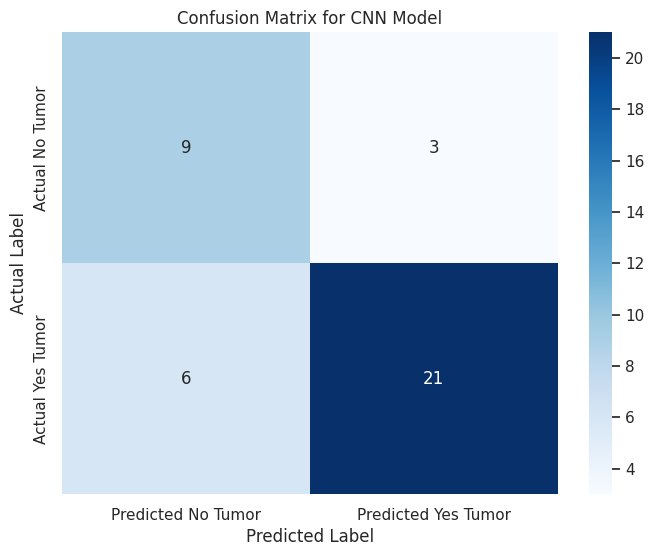

CNN model evaluation complete.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

print("Evaluating the CNN model performance on the test set...")

# 1. Set the model to evaluation mode
model_cnn.eval()

# 2. Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn.to(device)
print(f"Using device for evaluation: {device}")

# 3. Initialize empty lists to store true labels and predicted labels
all_labels = []
all_predictions = []

# 4. Iterate through the test_loader with torch.no_grad()
with torch.no_grad():
    for inputs, labels in test_loader:
        # 5. Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model outputs
        outputs = model_cnn(inputs)

        # Determine predicted classes
        _, predicted = torch.max(outputs, 1)

        # 6. Extend the true labels list with batch labels and predicted labels list with predicted classes
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 7. Calculate the classification report and print it
print("\n--- Classification Report for CNN Model ---")
print(classification_report(all_labels, all_predictions, target_names=['No Tumor', 'Yes Tumor']))

# 8. Calculate the confusion matrix
cm_cnn = confusion_matrix(all_labels, all_predictions)

# 9. Visualize the confusion matrix as a heatmap
print("\nGenerating and displaying confusion matrix for CNN Model...")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Tumor', 'Predicted Yes Tumor'],
            yticklabels=['Actual No Tumor', 'Actual Yes Tumor'])
plt.title('Confusion Matrix for CNN Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("CNN model evaluation complete.")

## Final Task

### Subtask:
Summarize the entire process, key findings, and the performance of the trained PyTorch CNN model for brain tumor detection.


## Summary:

### Data Analysis Key Findings

*   **Data Loading and Preprocessing**: The brain MRI image dataset, consisting of 253 images, was successfully loaded. Images were resized to 128x128 pixels, converted to PyTorch tensors, and normalized with a mean of 0.5 and standard deviation of 0.5. A custom `BrainTumorDataset` class was implemented for efficient data handling.
*   **Data Splitting**: The dataset was divided into training, validation, and test sets with a 70%/15%/15% split, resulting in 177 training images, 37 validation images, and 39 test images. `DataLoader` instances were created for each split with a batch size of 32.
*   **Exploratory Data Analysis (EDA)**: Sample images were visualized to confirm correct loading and preprocessing. The class distribution revealed an imbalance: 98 images (38.7%) were "No Tumor" and 155 images (61.3%) were "Yes Tumor", indicating a higher prevalence of tumor cases in the dataset.
*   **Model Architecture**: A `SimpleCNN` model was defined using PyTorch, featuring three convolutional blocks with ReLU activations, max-pooling, and dropout layers, followed by two fully connected layers for binary classification (tumor/no tumor). The input to the first fully connected layer was correctly calculated as 32768 features (128 channels \* 16x16 spatial dimension).
*   **Model Training**: The CNN model was trained for 10 epochs using the CPU. `nn.CrossEntropyLoss` was used as the loss function, and `Adam` optimizer with a learning rate of 0.001. Over 10 epochs, the training accuracy improved from 0.5424 to 0.8192, and validation accuracy increased from 0.6486 to 0.8378. Correspondingly, training loss decreased from 1.0830 to 0.4332, and validation loss decreased from 0.6608 to 0.4674.
*   **Model Evaluation**: On the test set, the trained CNN model achieved an overall accuracy of 0.77.
    *   For the "No Tumor" class: Precision was 0.60, Recall was 0.75, and F1-score was 0.67 (based on 12 samples).
    *   For the "Yes Tumor" class: Precision was 0.88, Recall was 0.78, and F1-score was 0.82 (based on 27 samples).
    *   The confusion matrix provided a clear visual breakdown of true positives, true negatives, false positives, and false negatives.

### Insights or Next Steps

*   **Address Class Imbalance**: The dataset shows a clear imbalance (61.3% 'Yes Tumor' vs. 38.7% 'No Tumor'). Techniques like weighted loss, oversampling the minority class, or undersampling the majority class during training could further improve the model's ability to correctly identify "No Tumor" cases, which currently has lower precision and F1-score.
*   **Hyperparameter Tuning and Regularization**: Given the limited number of epochs (10) and the steady improvement in validation accuracy, further training, possibly with a learning rate schedule or more aggressive regularization (e.g., higher dropout rates if overfitting is observed), could lead to better performance. Exploring different optimizers or CNN architectures might also yield improvements.
